Instalacja dodatkowego pakietu

In [7]:
!pip install stop-words
!pip install '/content/drive/My Drive/pl_spacy_model-0.1.0.tar.gz'

Processing ./drive/My Drive/pl_spacy_model-0.1.0.tar.gz
  Created wheel for pl-spacy-model: filename=pl_spacy_model-0.1.0-cp36-none-any.whl size=170055760 sha256=de18fa4618e00d5b3e10188a44f0a9034a591105dd2b710c87b2927c654278b7
  Stored in directory: /root/.cache/pip/wheels/b4/4c/1e/36e1976ddd91a3fe26391b3f45b078702d065021ae83dd69ae
Successfully built pl-spacy-model


Ładujemy pakiety

In [8]:
from google.colab import drive
import pandas as pd
from stop_words import get_stop_words
import pickle
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
import numpy as np
import spacy
import pl_spacy_model
import warnings
warnings.filterwarnings('ignore')
from datetime import datetime
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold
from xgboost import XGBClassifier

Podłączamy się do google dyska

In [4]:
drive.mount("/content/drive")

Mounted at /content/drive


In [6]:
dane = pd.read_csv('/content/drive/My Drive/wiersze_epoki.csv', encoding='cp1250')

In [ ]:
dane.head(5)

,wiersz,epoka,wiersz_parsed_1,epoka_code
0,Sukienkę miała w paseczki Perkalikową We włosa...,Pozytywizm,sukienkę miała w paseczki perkalikową włosach...,3
1,Ach jak mi smutno Mój anioł mnie rzucił W dale...,Pozytywizm,smutno anioł rzucił w daleki odbiegł świa...,3
2,Ach powiedz powiedz jaki Bóg W nadziemskie ubr...,Pozytywizm,powiedz powiedz bóg w nadziemskie ubrał sza...,3
3,Nie szczędź mi rajskich rozkoszy Różanych uste...,Pozytywizm,szczędź rajskich rozkoszy różanych ustek ża...,3
4,Anielskie śpiewają chóry W gwiaździstym błękit...,Pozytywizm,anielskie śpiewają chóry w gwiaździstym błękit...,3


Wstępne przygotowanie danych

In [ ]:
dane['wiersz_parsed_1'] = dane['wiersz'].str.replace("\r", " ")
dane['wiersz_parsed_1'] = dane['wiersz_parsed_1'].str.replace("\n", " ")
dane['wiersz_parsed_1'] = dane['wiersz_parsed_1'].str.replace("    ", " ")
dane['wiersz_parsed_1'] = dane['wiersz_parsed_1'].str.lower()

In [ ]:
punctuation_signs = list("?:!.,;-")

for punct_sign in punctuation_signs:
    dane['wiersz_parsed_1'] = dane['wiersz_parsed_1'].str.replace(punct_sign, '')

Polskie stopwordsy

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
stop_words = get_stop_words('pl')

In [ ]:
for stop_word in stop_words:

    regex_stopword = r"\b" + stop_word + r"\b"
    dane['wiersz_parsed_1'] = dane['wiersz_parsed_1'].str.replace(regex_stopword, '')

Przygotowanie zmiennej celu

In [ ]:
(dane.groupby(["epoka"])
    .agg(['count']))

,wiersz,wiersz_parsed_1
,count,count
epoka,,
Barok,400,400
Młoda Polska,3523,3523
Oświecenie,428,428
Pozytywizm,1719,1719
Renesans,780,780
Romantyzm,1726,1726
XX-lecie,3470,3470


In [ ]:
category_codes = {
    'Barok': 0,
    'Młoda Polska': 1,
    'Oświecenie': 2,
    'Pozytywizm': 3,
    'Renesans': 4,
    'Romantyzm': 5,
    'XX-lecie': 6
}

In [ ]:
dane['epoka_code'] = dane['epoka']
dane = dane.replace({'epoka_code':category_codes})

Lematyzacja

In [ ]:
nlp = pl_spacy_model.load()

nrows = len(dane)
lemmatized_text_list = []

for row in range(0, nrows):    
    print(row)
    lemmatized_list = []
    
    # Save the text and its words into an object
    text = dane.loc[row]['wiersz_parsed_1']

    # Iterate through every word to lemmatize
    doc = nlp(str(text))
    for token in doc:
        lemmatized_list.append(token.lemma_)
        
    # Join the list
    lemmatized_text = " ".join(lemmatized_list)
    
    # Append to the list containing the texts
    lemmatized_text_list.append(lemmatized_text)
    

In [ ]:
dane['wiersz_parsed_2'] = lemmatized_text_list

In [ ]:
dane.head(5)

,wiersz,epoka,wiersz_parsed_1,epoka_code,wiersz_parsed_2
0,Sukienkę miała w paseczki Perkalikową We włosa...,Pozytywizm,sukienkę miała w paseczki perkalikową włosach...,3,sukienka mieć w paseczek perkalikowy włos po...
1,Ach jak mi smutno Mój anioł mnie rzucił W dale...,Pozytywizm,smutno anioł rzucił w daleki odbiegł świa...,3,smutno anioł rzucić w daleki odbiec św...
2,Ach powiedz powiedz jaki Bóg W nadziemskie ubr...,Pozytywizm,powiedz powiedz bóg w nadziemskie ubrał sza...,3,powiedzieć powiedzieć bóg w nadziemski ubr...
3,Nie szczędź mi rajskich rozkoszy Różanych uste...,Pozytywizm,szczędź rajskich rozkoszy różanych ustek ża...,3,szczędź rajski rozkosz różany ustka żało...
4,Anielskie śpiewają chóry W gwiaździstym błękit...,Pozytywizm,anielskie śpiewają chóry w gwiaździstym błękit...,3,anielski śpiewać chór w gwiaździsty błękit mor...


Podział train/test

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(dane['wiersz_parsed_2'], 
                                                    dane['epoka_code'], 
                                                    test_size=0.30, 
                                                    random_state=8)

Zapis do pickle

In [ ]:
# X_train
with open('/content/drive/My Drive/X_train.pickle', 'wb') as output:
    pickle.dump(X_train, output)
    
# X_test    
with open('/content/drive/My Drive/X_test.pickle', 'wb') as output:
    pickle.dump(X_test, output)
    
# y_train
with open('/content/drive/My Drive/y_train.pickle', 'wb') as output:
    pickle.dump(y_train, output)
    
# y_test
with open('/content/drive/My Drive/y_test.pickle', 'wb') as output:
    pickle.dump(y_test, output)
    
# df
with open('/content/drive/My Drive/df.pickle', 'wb') as output:
    pickle.dump(dane, output)

Wczytanie z pickla

In [ ]:
dane = pd.read_pickle(r'/content/drive/My Drive/df.pickle')
X_train = pd.read_pickle(r'/content/drive/My Drive/X_train.pickle')
X_test = pd.read_pickle(r'/content/drive/My Drive/X_test.pickle')
y_train = pd.read_pickle(r'/content/drive/My Drive/y_train.pickle')
y_test = pd.read_pickle(r'/content/drive/My Drive/y_test.pickle')

Transformacja tekstu do TFIDF

In [ ]:
ngram_range = (1,2)
min_df = 10
max_df = 1.
max_features = 300

In [ ]:
tfidf = TfidfVectorizer(encoding='utf-8',
                        ngram_range=ngram_range,
                        stop_words=None,
                        lowercase=False,
                        max_df=max_df,
                        min_df=min_df,
                        max_features=max_features,
                        norm='l2',
                        sublinear_tf=True)
                        
features_train = tfidf.fit_transform(X_train).toarray()
labels_train = y_train
print(features_train.shape)

features_test = tfidf.transform(X_test).toarray()
labels_test = y_test
print(features_test.shape)

(8546, 300)
(3663, 300)


In [ ]:
with open('/content/drive/My Drive/tgidf.pickle', 'wb') as output:
    pickle.dump(tfidf.vocabulary_, output)

In [ ]:
from sklearn.feature_selection import chi2
import numpy as np

for Product, category_id in sorted(category_codes.items()):
    features_chi2 = chi2(features_train, labels_train == category_id)
    indices = np.argsort(features_chi2[0])
    feature_names = np.array(tfidf.get_feature_names())[indices]
    unigrams = [v for v in feature_names if len(v.split(' ')) == 1]
    bigrams = [v for v in feature_names if len(v.split(' ')) == 2]
    print("# '{}' category:".format(Product))
    print("  . Most correlated unigrams:\n. {}".format('\n. '.join(unigrams[-5:])))
    print("  . Most correlated bigrams:\n. {}".format('\n. '.join(bigrams[-2:])))
    print("")

Trenujemy model

In [ ]:
print(features_train.shape)
print(features_test.shape)

(8546, 300)
(3663, 300)


In [ ]:
params = {
        'min_child_weight': [2, 3, 5],
        'gamma': [2.5, 3, 3.5],
        'subsample': [0.5, 0.6, 0.7],
        'colsample_bytree': [0.7, 0.8, 0.9],
        'max_depth': [2, 3, 4],
        'learning_rate': [0.01, 0.02]    
        }

In [ ]:
folds = 3
param_comb = 5

skf = StratifiedKFold(n_splits=folds, shuffle = True, random_state = 1001)

xgb = XGBClassifier(learning_rate=0.02, n_estimators=1500, objective='multi:softprob',
                    silent=True, nthread=6, tree_method='gpu_hist', eval_metric='mlogloss')

random_search = RandomizedSearchCV(xgb, param_distributions=params, n_iter=param_comb, n_jobs=4, cv=skf.split(features_train, labels_train), verbose=3, random_state=1001 )

random_search.fit(features_train, labels_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  15 out of  15 | elapsed: 13.7min finished


RandomizedSearchCV(cv=<generator object _BaseKFold.split at 0x7f58da923678>,
                   error_score=nan,
                   estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                           colsample_bylevel=1,
                                           colsample_bynode=1,
                                           colsample_bytree=1,
                                           eval_metric='mlogloss', gamma=0,
                                           learning_rate=0.02, max_delta_step=0,
                                           max_depth=3, min_child_weight=1,
                                           missing=None, n_estimators=1500,
                                           n_jobs=1, nthread=6,...
                                           seed=None, silent=True, subsample=1,
                                           tree_method='gpu_hist',
                                           verbosity=1),
                   iid='deprecated', n_i

In [ ]:
print("Najlepsze hiperparametry:")
print(random_search.best_params_)
print("")
print("Średnie accuracy:")
print(random_search.best_score_) 

The best hyperparameters from Grid Search are:
{'subsample': 0.7, 'min_child_weight': 2, 'max_depth': 3, 'learning_rate': 0.02, 'gamma': 3.5, 'colsample_bytree': 0.9}

The mean accuracy of a model with these hyperparameters is:
0.5609641269753629


In [ ]:
best_xgb = random_search.best_estimator_

In [ ]:
best_xgb.fit(features_train, labels_train)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.9, eval_metric='mlogloss',
              gamma=3.5, learning_rate=0.02, max_delta_step=0, max_depth=3,
              min_child_weight=2, missing=None, n_estimators=1500, n_jobs=1,
              nthread=6, objective='multi:softprob', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=True, subsample=0.7, tree_method='gpu_hist', verbosity=1)

In [ ]:
xgb_pred = best_xgb.predict(features_test)

Predict z modelu

In [ ]:
xgb_pred[:10]

array([6, 3, 1, 6, 6, 5, 6, 6, 1, 1])

In [ ]:
xgb_pred_prob = best_xgb.predict_proba(features_test)

In [ ]:
print("Accuracy na zbiorze train:")
print(accuracy_score(labels_train, best_xgb.predict(features_train)))

The training accuracy is: 
0.7683126608939855


In [ ]:
print("Accuracy na zbiorze test:")
print(accuracy_score(labels_test, xgb_pred))

The test accuracy is: 
0.5978705978705978


In [ ]:
print(classification_report(labels_test,xgb_pred))

Classification report
              precision    recall  f1-score   support

           0       0.52      0.14      0.22       124
           1       0.60      0.69      0.64      1089
           2       0.60      0.36      0.45       125
           3       0.53      0.33      0.41       490
           4       0.77      0.57      0.65       240
           5       0.57      0.44      0.50       512
           6       0.59      0.79      0.68      1083

    accuracy                           0.60      3663
   macro avg       0.60      0.47      0.51      3663
weighted avg       0.59      0.60      0.58      3663



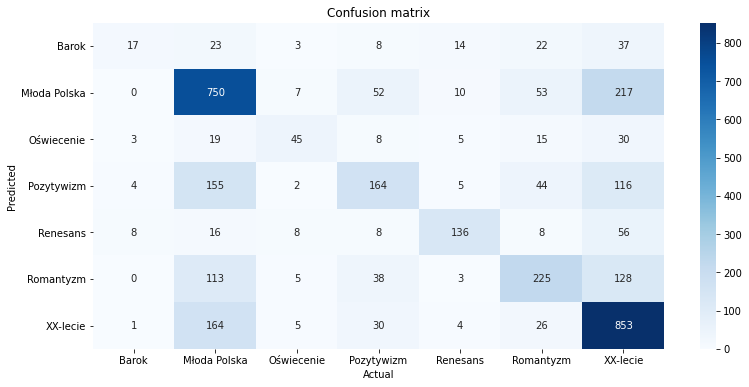

In [ ]:
aux_df = dane[['epoka', 'epoka_code']].drop_duplicates().sort_values('epoka_code')
conf_matrix = confusion_matrix(labels_test, xgb_pred)
plt.figure(figsize=(12.8,6))
sns.heatmap(conf_matrix, 
            annot=True,
            xticklabels=aux_df['epoka'].values, 
            yticklabels=aux_df['epoka'].values,
            cmap="Blues",
            fmt='g')
plt.ylabel('Predicted')
plt.xlabel('Actual')
plt.title('Confusion matrix')
plt.show()

Zapis modelu do pickle

In [ ]:
with open('/content/drive/My Drive/best_xgb.pickle', 'wb') as output:
    pickle.dump(best_xgb, output)